# Introducción a RAG (Retrieval-Augmented Generation)

Autor: Ing. Ángel Nicolás Heredia (LIDESIA)

Directora: Dra. Laura Diaz Dávila (LIDESIA)

Google Colab permite ejecutar código Python en un entorno de computación en la nube. La versión gratuita te brinda acceso a recursos compartidos, que incluyen:

✅ Sistema operativo\
Basado en Linux (Debian/Ubuntu).

Python 3.11 (a julio de 2025).

✅ CPU\
CPU virtual (Intel Xeon) con 2 núcleos.
Entre 12 GB y 16 GB de RAM disponibles, dependiendo del entorno.

✅ GPU\
El modelo más común para las versión gratuita es: \
**NVIDIA T4 con 16 GB de VRAM**


**CUDA** (Compute Unified Device Architecture) es una plataforma de computación paralela y un modelo de programación desarrollado por NVIDIA que permite usar las GPUs para cómputo general, no solo para gráficos.

In [ ]:
# ============================================================================
# INSTALACIÓN DE LIBRERÍAS PRINCIPALES
# ============================================================================

# LangChain: Framework principal para aplicaciones con LLM
# - langchain: Librería base con componentes esenciales
# - langchain-community: Integraciones con servicios externos
# - langchain-huggingface: Integración específica con HuggingFace
!pip install -qU langchain langchain-community langchain-huggingface

# Embeddings y búsqueda vectorial
# - sentence-transformers: Para crear representaciones vectoriales de texto
# - faiss-cpu: Base de datos vectorial para búsqueda de similitud eficiente
!pip install -qU sentence-transformers faiss-cpu

# Transformers: Librería de HuggingFace para modelos pre-entrenados
# - transformers: Acceso a modelos
# - accelerate: Optimización para entrenamiento e inferencia
!pip install -q transformers accelerate

!pip install -q pypdf  # Para archivos PDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

In [ ]:
# Conectarse a drive para manejar archivos de mi unidad
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importar todas las librerías necesarias

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from transformers import AutoTokenizer, AutoModelForCausalLM

## Usar el modelo sin RAG


Usaremos el modelo **Qwen2.5-3B-Instruct**: \
Qwen2.5-3B-Instruct es un modelo de lenguaje grande (LLM) de código abierto desarrollado por el equipo Qwen de **Alibaba Cloud**. 3B hace referencia al número de parámetros del modelo, aproximadamente 3 mil millones. Está específicamente entrenado para seguir órdenes, responder preguntas y mantener conversaciones coherentes, haciéndolo mucho más útil para aplicaciones de chatbot y asistentes. Tiene un excelente desempeño en más de 29 idiomas y puede procesar contextos de entrada de hasta 32,768 tokens y generar respuestas de hasta 8,192 tokens.

Este tamaño de modelo es posible importarlo y usarlo en la computadora que nos facilita Colab, con una GPU de 16 GB de VRAM.




La diferencia de tamaño entre Qwen2.5-3B-Instruct y los grandes modelos como GPT-4o o Gemini 1.5 Pro es grande. Estos grandes modelos de lenguaje, poseen una cantidad de parametros que andan por el orden del billon, es decir tres ordenes de magnitud más que el modelo que usaremos aquí.

A continuación vamos a importar un modelo de lenguaje desde Hugging Face y cargarlo en la GPU gratuita que nos ofrece Google Colab.

También vamos a traer el tokenizador, que es el componente encargado de dividir el texto de entrada en fragmentos (llamados tokens).

Usaremos las librerías transformers y accelerate, que están diseñadas para trabajar eficientemente sobre GPUs NVIDIA — ya que gran parte de la tecnología que utilizan los modelos grandes de IA está optimizada para CUDA, el ecosistema de cómputo en GPU de NVIDIA.

In [ ]:
# ============================================================================
# CARGAR EL MODELO LLM
# ============================================================================
import torch

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

print("✅ Modelo cargado exitosamente!")
print(f"Memoria GPU usada: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Modelo cargado exitosamente!
Memoria GPU usada: 5.75 GB


Vamos a crear algunas funciones para poder pregunarle al modelo directamente.

In [ ]:
def preguntar_modelo(pregunta, max_tokens=512):

    """Función simple para hacer preguntas al modelo"""

    messages = [
        {"role": "system", "content": "Eres un modelo de lenguaje de la familia Qwen, \
                                       actua como un experto en eficiencia energética de viviendas en Argentina. \
                                       Proporciona respuestas técnicas precisas basadas en normativas locales"},
        {"role": "user", "content": pregunta}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenizar
    model_inputs = tokenizer(
        [text],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    ).to("cuda")

    # Generar respuesta
    generated_ids = model.generate(
        input_ids=model_inputs.input_ids,
        attention_mask=model_inputs.attention_mask,  # elimina el warning
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=0.1, # controla la creatividad (0.1 es muy precisa y poco creativa)
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    # Decodificar solo la parte nueva
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


In [ ]:
from IPython.display import Markdown, display

def mostrar_respuesta_formateada(texto):
    # Reemplaza los guiones por bullets reales y agrega saltos de línea más definidos
    texto = texto.replace("- ", "* ")  # bullets Markdown
    display(Markdown(texto))

In [ ]:
respuesta = preguntar_modelo("¿Qué requisitos debe cumplir un profesional para ser auditor dentro del sistema PRONEV?")
mostrar_respuesta_formateada(respuesta)

El Sistema Nacional de Auditoría Energética (SNAE) es una herramienta importante para promover la eficiencia energética y la reducción de emisiones de gases de efecto invernadero en el país. En Argentina, el Sistema Nacional de Auditoría Energética (SNAE) está vinculado al Programa Nacional de Eficiencia Energética Vivienda (PRONEV), que busca mejorar la eficiencia energética en los edificios residenciales.

Para ser considerado un auditor dentro del PRONEV, se requiere cumplir con ciertos requisitos técnicos y profesionales. Estos pueden variar según las normativas locales y regionales, pero generalmente incluyen:

1. **Educación**: Un nivel mínimo de educación superior en ingeniería eléctrica, ingeniería civil, arquitectura o alguna otra carrera relacionada con la energía y la construcción.

2. **Experiencia Profesional**: Algunos programas pueden requerir experiencia previa en auditorías energéticas o en el campo de la eficiencia energética.

3. **Certificación**: Es posible que se necesite una certificación específica para ser considerado un auditor PRONEV. Esta certificación puede estar vinculada a certificaciones internacionales como ISO 50001 o a certificaciones nacionales específicas.

4. **Formación Continuada**: La formación continua es crucial en este campo. Los auditores deben mantenerse actualizados sobre las últimas tecnologías y normativas de eficiencia energética.

5. **Conocimientos Técnicos**: Debe tener conocimientos sólidos sobre sistemas de calefacción, refrigeración, iluminación y otros sistemas de energía en edificios residenciales.

6. **Habilidades de Auditoría**: Debido a que el auditor debe evaluar y recomendar mejoras en la eficiencia energética, deben tener habilidades de análisis, resolución de problemas y comunicación efectiva.

7. **Normativas y Regulaciones**: Deberá estar familiarizado con las normativas locales y regionales de eficiencia energética, como la Norma Argentina NBR 15500 y otras regulaciones vigentes.

Es importante notar que estos requisitos pueden variar dependiendo de la región o del organismo específico que implementa el PRONEV. Para obtener información exacta y actualizada, se

## Usar el modelo con RAG

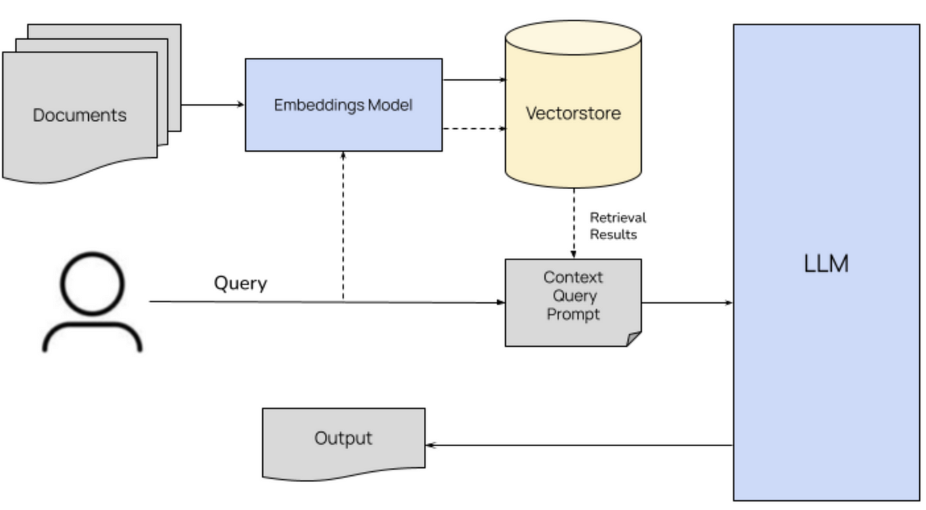

In [ ]:
# Lista con los path de los archivos
file_paths = ["/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2023-5-APN-SE_MEC.pdf",
              "/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf",
              "/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2025-129-APN-SE_MEC.pdf",
]

all_documents = []

# Iteramos sobre cada archivo para cargarlo
for path in file_paths:
    try:
        # Usar PyPDFLoader para archivos PDF
        loader = PyPDFLoader(path)
        documents = loader.load()
        all_documents.extend(documents)
        print(f"✅ Documento '{path}' cargado exitosamente - {len(documents)} páginas.")
    except Exception as e:
        print(f"❌ Error al cargar el documento '{path}': {e}")

# Verificamos el resultado
print(f"\nTotal de documentos cargados: {len(all_documents)}")

# Inspeccionar el contenido
if all_documents:
    print("\n--- Ejemplo de contenido del primer documento ---")
    print(f"Página: {all_documents[0].metadata}")
    print(all_documents[0].page_content[:300])  # Primeros 300 caracteres

✅ Documento '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2023-5-APN-SE_MEC.pdf' cargado exitosamente - 4 páginas.
✅ Documento '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf' cargado exitosamente - 26 páginas.
✅ Documento '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2025-129-APN-SE_MEC.pdf' cargado exitosamente - 13 páginas.

Total de documentos cargados: 43

--- Ejemplo de contenido del primer documento ---
Página: {'producer': 'iText® 7.1.7 ©2000-2019 iText Group NV (AGPL-version); modified using iText® 7.1.7 ©2000-2019 iText Group NV (AGPL-version)', 'creator': 'PyPDF', 'creationdate': '2023-01-05T11:24:51-03:00', 'moddate': '2023-01-06T10:14:19-03:00', 'changed': '20100127;11124500', 'created': '0;0', 'generator': 'OpenOffice.org 3.1  (Win32)', 'info 1': '', 'info 2': '', 'info 3': '', 'info 4': '', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_

En esta celda se utiliza la clase **`RecursiveCharacterTextSplitter`** para dividir los documentos en fragmentos más pequeños o chunks, lo cual es útil para tareas como el procesamiento de texto o la indexación para recuperación de información. El parámetro `chunk_size=500` indica que cada fragmento tendrá hasta 500 caracteres, y `chunk_overlap=100` asegura que haya un solapamiento de 50 caracteres entre chunks consecutivos, lo que ayuda a mantener el contexto entre fragmentos adyacentes.

In [ ]:
# Dividir en chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(all_documents)
print(f"✅ Documento dividido en {len(chunks)} chunks.")

✅ Documento dividido en 220 chunks.


Se crean los embeddings y se construye una base vectorial (vectorstore) para facilitar la búsqueda semántica. Se utiliza el modelo "`all-MiniLM-L6-v2`" a través de la clase HuggingFaceEmbeddings. Este modelo convierte cada fragmento de texto (chunk) en un vector numérico que representa su significado. Luego, estos vectores se almacenan en una estructura de datos `FAISS`, una librería optimizada para búsquedas rápidas en espacios vectoriales, lo que permite recuperar información de manera eficiente basada en similitud semántica.

In [ ]:
# Crear embeddings y vectorstore
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cuda'}
)
vectorstore = FAISS.from_documents(chunks, embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
import textwrap

# Crear el retriever con k variable
def crear_retriever(k=4):
    return vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": k}
    )

# Función para buscar documentos relevantes
def buscar_documentos_relevantes(pregunta, k=3):
    """Busca documentos relevantes para una pregunta"""
    retriever = crear_retriever(k)
    documentos = retriever.get_relevant_documents(pregunta)
    return documentos

# Prueba la búsqueda
pregunta_test = "¿Qué requisitos debe cumplir un profesional para ser auditor dentro del sistema PRONEV?"
docs_relevantes = buscar_documentos_relevantes(pregunta_test)

print("📄 Documentos encontrados:")
for i, doc in enumerate(docs_relevantes, 1):
    print(f"\n{i}. {doc.page_content[:70]}...")
    if hasattr(doc, 'metadata'):
        print(f"   Fuente: {doc.metadata}")

📄 Documentos encontrados:

1. Tendrán a cargo  realizar las Auditorías del PRONEV.  Deberán (i) mant...
   Fuente: {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf', 'total_pages': 26, 'page': 9, 'page_label': '10'}

2. EJECUTORA NACIONAL. 
i. Informar a la UNIDAD EJECUTORA NACIONAL      l...
   Fuente: {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf', 'total_pages': 26, 'page': 8, 'page_label': '9'}

3. 1. Nombre, apellido, DNI y profesión. 
2. Usuario del AEV correspondie...
   Fuente: {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# Función principal del RAG
def responder_con_rag(pregunta, k=4, max_tokens=512):
    """
    Función principal del RAG que combina retrieval + generation
    """
    # 1. RETRIEVAL
    documentos_relevantes = buscar_documentos_relevantes(pregunta, k=k)

    # 2. CONTEXTO
    contexto = "\n\n".join([doc.page_content for doc in documentos_relevantes])

    # 3. PROMPT LIMPIO
    prompt = textwrap.dedent(f"""
        Basándote únicamente en el siguiente CONTEXTO sobre eficiencia energética en Argentina,
        responde la PREGUNTA de manera precisa.

        CONTEXTO:
        '''
        {contexto}
        '''
        PREGUNTA:
        {pregunta}

""")

    # 4. GENERACIÓN
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    return {
        'respuesta': response.strip(),
        'documentos_fuente': documentos_relevantes,
        'contexto_usado': contexto
    }

In [ ]:
def comparar_respuestas(pregunta):
    """Compara respuesta con y sin RAG"""

    print("="*80)
    print(f"🔍 PREGUNTA: {pregunta}")
    print("="*80)

    # Respuesta SIN RAG
    print("\n🚫 RESPUESTA SIN RAG:")
    print("-" * 40)
    respuesta_sin_rag = preguntar_modelo(pregunta)
    mostrar_respuesta_formateada(respuesta_sin_rag)

    # Respuesta CON RAG
    print("\n✅ RESPUESTA CON RAG:")
    print("-" * 40)
    resultado_rag = responder_con_rag(pregunta)
    mostrar_respuesta_formateada(resultado_rag['respuesta'])

    # Mostrar fuentes
    print("\n📚 FUENTES UTILIZADAS:")
    print("-" * 40)
    for i, doc in enumerate(resultado_rag['documentos_fuente'], 1):
        print(f"{i}. {doc.page_content[:80]}...")
        if hasattr(doc, 'metadata') and doc.metadata:
            print(f"   📄 {doc.metadata}")

    return resultado_rag

In [ ]:
# Preguntas específicas sobre eficiencia energética en Argentina
preguntas_test = [
    "¿Qué requisitos debe cumplir un profesional para ser auditor dentro del sistema PRONEV?",
    "¿Qué se entiende por 'Etiqueta de Eficiencia Energética' según la normativa?"
]

# Probar cada pregunta
for pregunta in preguntas_test:
    resultado = comparar_respuestas(pregunta)
    print("\n" + "="*100 + "\n")

🔍 PREGUNTA: ¿Qué requisitos debe cumplir un profesional para ser auditor dentro del sistema PRONEV?

🚫 RESPUESTA SIN RAG:
----------------------------------------


El Sistema Nacional de Auditoría Energética (SNAE) es un marco regulatorio que aplica en Argentina, y su equivalente en el ámbito de la eficiencia energética de viviendas se refiere al Programa Nacional de Evaluación de Eficiencia Energética de Viviendas (PRONEV). Sin embargo, no existe un sistema específico llamado "Sistema PRONEV" para auditorías de viviendas.

Para ser un auditor en el contexto de la evaluación de eficiencia energética de viviendas, generalmente se requieren los siguientes requisitos:

1. **Educación**: Un nivel de educación superior en ingeniería eléctrica, electricidad, arquitectura, ingeniería civil o cualquier otro campo relacionado con la energía y la construcción.

2. **Experiencia Profesional**: Algunos programas pueden requerir una experiencia mínima en el campo de la eficiencia energética de viviendas. Esto puede variar según la institución o entidad que emita el certificado de auditor.

3. **Certificación**: Existen certificaciones específicas para auditores de eficiencia energética. En Argentina, por ejemplo, la Asociación Argentina de Eficiencia Energética (AAEE) ofrece certificaciones en eficiencia energética. Para ser un auditor PRONEV, uno podría necesitar una certificación en eficiencia energética de viviendas.

4. **Formación Continuada**: La formación continua es crucial en este campo, ya que las normativas y tecnologías cambian constantemente. Los auditores deben mantenerse actualizados sobre las últimas tendencias y regulaciones.

5. **Conocimientos Técnicos**: Deben tener conocimientos sólidos sobre sistemas de calefacción, refrigeración, iluminación, ventanas y otros elementos de la vivienda que afectan a la eficiencia energética.

6. **Habilidades de Auditoría**: Las habilidades de investigación, análisis y comunicación son cruciales para realizar auditorías efectivas.

7. **Licencia o Certificado**: Dependiendo de la entidad o institución que emita el certificado, podrían requerir un certificado de auditoría emitido por una entidad autorizada.

Es importante verificar directamente con la entidad o institución que emite el certificado de auditoría para obtener información precisa y actualizada sobre los requisitos específicos para ser


✅ RESPUESTA CON RAG:
----------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


RESPUESTA:

Un profesional debe cumplir los siguientes requisitos para ser auditor dentro del sistema PRONEV:

1. **Registro en el Registro Nacional de Etiquetadores de Vivienda**: Los profesionales deben estar registrados en el Registro Nacional de Etiquetadores de Vivienda.

2. **Certificado de Aprobación del Curso de Etiquetado**: Deben tener un certificado de aprobación del curso de etiquetado otorgado por la Unidad Ejecutora Nacional.

3. **Curso de Auditor**: Deben haber completado y aprobado el curso de auditor otorgado por la Unidad Ejecutora Nacional.

4. **Inscripción en el Registro Nacional de Auditores**: Los auditores habilitados deberán inscribirse en el Registro Nacional de Auditores a partir de la publicación de la presente medida.

5. **Cumplimiento de Lineamientos de la Unidad Ejecutora Nacional**: Los auditores deben cumplir con los lineamientos de la Unidad Ejecutora Nacional para el proceso de auditoría del PRONEV.

6. **Actualizar Datos Personales y Profesionales**: Los profesionales deben mantener actualizados sus datos personales y profesionales en su perfil de usuario del AEV.

7. **Informar a la Unidad Ejecutora Nacional**: El titular o los titulares registrales del inmueble sujeto a VIVIENDA, objeto del proceso de etiquetado de eficiencia energética previsto en el PRONEV, pueden informar a la Unidad Ejecutora Nacional los profesionales que designen para desempeñarse como auditores en su jurisdicción.

8. **Cumplir con Requisitos de Actualización**: Los profesionales deben cumplir con los requerimientos de actualización que determine la Unidad Ejecutora Nacional. 

Estos son los requisitos principales que deben cumplir los profesionales para ser considerados auditores dentro del sistema PRONEV. 

**Nota:** La información proporcionada en el contexto puede variar según las actualizaciones regulares de la Unidad Ejecutora Nacional. Es recomendable consultar las últimas medidas y directrices oficiales para obtener la información más precisa y actualizada. 

---

Esta respuesta es precisa y completa basándose en el contexto proporcionado. Si hay alguna otra pregunta o necesitas más detalles específicos,


📚 FUENTES UTILIZADAS:
----------------------------------------
1. Tendrán a cargo  realizar las Auditorías del PRONEV.  Deberán (i) mantener actua...
   📄 {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf', 'total_pages': 26, 'page': 9, 'page_label': '10'}
2. EJECUTORA NACIONAL. 
i. Informar a la UNIDAD EJECUTORA NACIONAL      los Profesi...
   📄 {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2024-595-APN-SE_MEC.pdf', 'total_pages': 26, 'page': 8, 'page_label': '9'}
3. 1. Nombre, apellido, DNI y profesión. 
2. Usuario del AEV correspondiente. 
3. C...
   📄 {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:50:00+00:00', 'source': '/conten

La Etiqueta de Eficiencia Energética es una herramienta utilizada para evaluar y clasificar el rendimiento energético de los productos, en este caso, las viviendas. En Argentina, esta clasificación se realiza en base a la Norma Técnica NTE 1024:2017, que establece criterios para la calificación de la eficiencia energética de edificios residenciales.

Esta normativa divide a los edificios en cinco categorías, desde la más baja (C) hasta la más alta (A+), donde:

* **A**: Edificio con un alto nivel de eficiencia energética.
* **B**: Edificio con un nivel medio de eficiencia energética.
* **C**: Edificio con un nivel bajo de eficiencia energética.
* **D**: Edificio con un nivel muy bajo de eficiencia energética.
* **C** y **D**: Edificios que no cumplen con los requisitos mínimos de eficiencia energética.

Es importante tener en cuenta que la etiqueta de eficiencia energética no solo refleja el rendimiento energético del edificio en sí, sino también la calidad de su diseño, construcción y mantenimiento. Además, esta clasificación puede variar dependiendo del tipo de edificio (residencial, comercial, industrial, etc.) y del año de construcción.

Para obtener una clasificación precisa, es necesario realizar un análisis detallado del edificio, incluyendo factores como la orientación solar, la ventilación, la insulación, la iluminación y la instalación de sistemas de calefacción y refrigeración.


✅ RESPUESTA CON RAG:
----------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


RESPUESTA:
        Según la normativa mencionada, la 'Etiqueta de Eficiencia Energética' es un medio diseñado para clasificar las viviendas según su grado de eficiencia en el requerimiento global de energía primaria. Esta etiqueta permite identificar la eficiencia energética de las viviendas de acuerdo con un sistema uniforme en todo el territorio nacional. Se trata de un elemento visual que refleja la eficiencia energética de una vivienda, basándose en su requerimiento global de energía primaria. 

        En este contexto, la Etiqueta de Eficiencia Energética es un instrumento clave para promover la eficiencia energética en todo el país, facilitando la comparación y la selección de viviendas más eficientes. 

        [FIN]


📚 FUENTES UTILIZADAS:
----------------------------------------
1. implementar un sistema de etiquetado de eficiencia energética de vivienda unific...
   📄 {'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-06-03T19:51:50+00:00', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2025-129-APN-SE_MEC.pdf', 'total_pages': 13, 'page': 0, 'page_label': '1'}
2. unificado para todo el territorio nacional, que permita clasificarlas según su g...
   📄 {'producer': 'iText® 7.1.7 ©2000-2019 iText Group NV (AGPL-version); modified using iText® 7.1.7 ©2000-2019 iText Group NV (AGPL-version)', 'creator': 'PyPDF', 'creationdate': '2023-01-05T11:24:51-03:00', 'moddate': '2023-01-06T10:14:19-03:00', 'changed': '20100127;11124500', 'created': '0;0', 'generator': 'OpenOffice.org 3.1  (Win32)', 'info 1': '', 'info 2': '', 'info 3': '', 'info 4': '', 'source': '/content/drive/MyDrive/adscripcion/Charla_colegio_ing_civil/documentacion/RS-2

✅ **Comparación 1: Requisitos para ser auditor del PRONEV**\
🟥 **Sin RAG**:

Mezcla conceptos ajenos al PRONEV (como el “SNAE” que no aparece en ninguna de las resoluciones).

Usa intuición general sobre eficiencia energética, pero no menciona ningún requisito normativo real.

Habla de instituciones no relevantes (AAEE).

🟩 **Con RAG**:

Extrae información directa de la resolución: cursos, registros, funciones y condiciones.

Incluye detalles clave como la actualización de datos en el AEV o el rol de la Unidad Ejecutora Nacional.

Es una respuesta precisa, verificable y completa.

✅ **Comparación 2: ¿Qué es la Etiqueta de Eficiencia Energética?**\
🟥 **Sin RAG:**

Describe un sistema genérico de etiquetado (incluso con la Norma NTE 1024:2017), pero no es el del PRONEV.

Cita escalas incorrectas (A+, C, D...), lo cual puede confundir al usuario final.

Carece de referencia al AEV, la escala de A a G, o al IPE.

🟩 **Con RAG**:

Define la etiqueta según su función normativa: clasificación por requerimiento de energía primaria, aplicación nacional, uso visual.

Está en línea con el documento oficial.

Le faltó incluir la escala (A–G) y el IPE.

**Beneficios de ejecutar los modelos de forma local:**

**Privacidad y seguridad de los datos**: Sus datos confidenciales nunca salen de su equipo. Ideal para información personal o empresarial confidencial.\
**Control y personalización**: Tiene control total sobre el modelo, su configuración y cómo se integra en sus flujos de trabajo.\
**Reducción de costos** (a largo plazo): Al usar modelos locales, elimina los costos de usar API en la nube, especialmente con un uso intensivo.\
**Operación sin conexión**: Capacidad de operar sin conexión a internet (una vez descargado el modelo).

**Desafios de ejecutar los modelos de forma local:**

**Requisitos de hardware**: Los LLM son exigentes. Necesita una CPU decente, suficiente RAM y, principalmente, una GPU.\
**Complejidad de configuración**: Poner todo en funcionamiento requiere varios conocimientos técnicos.\
**Tamaño del model**o: Los modelos LLM pequeños para uso local pueden ocupar varios gigabytes de espacio.\
**Conocimiento limitado del modelo LLM pequeño**: Los modelos base solo conocen la fecha de su último entrenamiento.